# SIGNAL vs BKG, 1000 jet/imgs

In [2]:
import sys
sys.path.append('/eos/user/f/fcampono/.local/lib/python3.11/site-packages')  

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import gaussian_blur
import cv2
from glob import glob
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import timm
import torch.nn as nn
import random
from sklearn.model_selection import train_test_split
from torchvision import models

In [ ]:
# ==== PARAMETRS ====
BATCH_SIZE = 16
SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class NPYDataset(Dataset):
    def __init__(self, file_paths, labels, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.augment = augment

        if augment:
            self.transform = T.Compose([
                T.ToTensor(),
                T.Resize((SIZE, SIZE)),
                T.RandomRotation(20),
                T.RandomHorizontalFlip(p=0.3)
            ])
        else:
            self.transform = T.Compose([
                T.ToTensor(),
                T.Resize((SIZE, SIZE))
            ])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        image = np.load(img_path)

        # Se immagine è nera o costante → non normalizzare
        if np.max(image) == np.min(image):
            image_f = image.astype(np.float32)
        else:
            image_n = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
            image_f = image_n.astype(np.float32)

        # Conversione in RGB
        if image_f.ndim == 2:
            image_rgb = np.stack([image_f] * 3, axis=-1)
        elif image_f.ndim == 3 and image_f.shape[-1] == 1:
            image_rgb = np.repeat(image_f, 3, axis=-1)
        elif image_f.ndim == 3 and image_f.shape[-1] == 3:
            image_rgb = image_f
        else:
            raise ValueError(f"Formato immagine inatteso: {image_f.shape}")

        image_final = self.transform(image_rgb)

        return image_final, torch.tensor(label, dtype=torch.long), img_path


# ==== Caricamento dataset ====
def load_dataset_paths(base_dir):
    classes = ['npy_TTBar_1000', 'npy_QCD_1000', 'npy_Black']
    file_paths, labels = [], []
    for i, cls in enumerate(classes):
        paths = glob(os.path.join(base_dir, cls, '*.npy'))
        file_paths.extend(paths)
        labels.extend([i] * len(paths))
    return file_paths, labels


# === Insertion e deletion con e senza smearing
def apply_mask(image: torch.Tensor,
               mask: np.ndarray,
               mode: str = 'deletion',
               baseline_type: str = 'zero',
               blur_kernel: int = 61,
               blur_sigma: float = 5.0) -> torch.Tensor:
    
    device = image.device
    mask_t = torch.tensor(mask, dtype=torch.float32, device=device)
    mask_t = mask_t.unsqueeze(0).expand_as(image)

    # Scelta della baseline
    if baseline_type == 'zero':
        baseline = torch.zeros_like(image)

    elif baseline_type == 'blur':
        baseline = gaussian_blur(
            image,
            kernel_size=blur_kernel,
            sigma=blur_sigma
        )

    else:
        raise ValueError("baseline_type must be 'zero' or 'blur'")

    # Applicazione deletion / insertion
    if mode == 'deletion':
        return image * (1 - mask_t) + baseline * mask_t
    elif mode == 'insertion':
        return baseline * (1 - mask_t) + image * mask_t
    else:
        raise ValueError("Mode must be 'deletion' or 'insertion'.")


def run_curve(model,
              image: torch.Tensor,
              cam: np.ndarray,
              target_class: int,
              mode: str = 'deletion',
              steps: int = 20,
              baseline_type: str = 'zero',
              blur_kernel: int = 61,
              blur_sigma: float = 5.0):

    model.eval()
    image = image.clone().detach().unsqueeze(0).to(next(model.parameters()).device)

    # ✅ Se il CAM è tutto zero o NaN → sostituisci con maschera uniforme
    if np.isnan(cam).any() or np.max(cam) == 0:
        cam = np.ones((image.shape[2], image.shape[3]), dtype=np.float32)
    else:
        cam = cv2.resize(cam, (image.shape[2], image.shape[3]))
        cam = cam / (cam.max() + 1e-8)

    flat = cam.flatten()
    sorted_indices = np.argsort(flat)[::-1]
    scores = []

    for i in range(steps + 1):
        percent = i / steps
        num_pixels = int(flat.size * percent)

        mask = np.zeros_like(flat)
        mask[sorted_indices[:num_pixels]] = 1
        mask = mask.reshape(cam.shape)

        masked_image = apply_mask(
            image=image[0],
            mask=mask,
            mode=mode,
            baseline_type=baseline_type,
            blur_kernel=blur_kernel,
            blur_sigma=blur_sigma
        ).unsqueeze(0)

        with torch.no_grad():
            output = F.softmax(model(masked_image), dim=1)
            score = output[0, target_class].item()
            scores.append(score)

    return scores

In [5]:
BASE_DIR = "/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000"

train_files, train_labels = load_dataset_paths(os.path.join(BASE_DIR, 'train'))
val_files, val_labels = load_dataset_paths(os.path.join(BASE_DIR, 'validation'))
test_files, test_labels = load_dataset_paths(os.path.join(BASE_DIR, 'test'))

train_dataset = NPYDataset(train_files, train_labels, augment=True)
val_dataset = NPYDataset(val_files, val_labels, augment=False)
test_dataset = NPYDataset(test_files, test_labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [37]:
# ====== 1. Modello ======

# Carica EfficientNetV2-S pre-addestrata su ImageNet-1k
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    #nn.Linear(in_features, 1024),
    nn.Linear(in_features, 512),

    nn.SiLU(),
    nn.Dropout(0.2),
   # nn.Linear(1024, 512),
    #nn.SiLU(),
    #nn.Dropout(0.3),
    nn.Linear(512, 3)
)

model = model.to(DEVICE)

n_epochs = 15
early_stopping_patience = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


# ====== 3. Training e valutazione ======
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels, _ in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

# ====== 4. Training loop con early stopping ======

best_val_loss = float('inf')
epochs_no_improve = 0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'epoch': [], 'lr': []
}

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    #scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['epoch'].append(epoch)
    history['lr'].append(current_lr)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model, "effnetv2s_sig_bkg_1000.pt")
        print("✔️ Saved best model.")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stopping_patience:
        print("🛑 Early stopping.")
        break

Epoch 1/15


Train Loss: 0.8828 | Val Loss: 0.6355 | Train Acc: 0.7900 | Val Acc: 0.8867 | LR: 0.000010
✔️ Saved best model.
Epoch 2/15


Train Loss: 0.4360 | Val Loss: 0.1168 | Train Acc: 0.9608 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 3/15


Train Loss: 0.1591 | Val Loss: 0.0299 | Train Acc: 0.9800 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 4/15


Train Loss: 0.0725 | Val Loss: 0.0114 | Train Acc: 0.9933 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 5/15


Train Loss: 0.0515 | Val Loss: 0.0084 | Train Acc: 0.9892 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 6/15


Train Loss: 0.0344 | Val Loss: 0.0047 | Train Acc: 0.9958 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 7/15


Train Loss: 0.0292 | Val Loss: 0.0027 | Train Acc: 0.9942 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 8/15


Train Loss: 0.0304 | Val Loss: 0.0020 | Train Acc: 0.9933 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 9/15


Train Loss: 0.0426 | Val Loss: 0.0022 | Train Acc: 0.9917 | Val Acc: 1.0000 | LR: 0.000010
⚠️ No improvement for 1 epoch(s).
Epoch 10/15


Train Loss: 0.0348 | Val Loss: 0.0016 | Train Acc: 0.9925 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 11/15


Train Loss: 0.0143 | Val Loss: 0.0013 | Train Acc: 0.9992 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 12/15


Train Loss: 0.0121 | Val Loss: 0.0009 | Train Acc: 0.9958 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 13/15


Train Loss: 0.0060 | Val Loss: 0.0006 | Train Acc: 1.0000 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 14/15


Train Loss: 0.0121 | Val Loss: 0.0005 | Train Acc: 0.9983 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.
Epoch 15/15


Train Loss: 0.0126 | Val Loss: 0.0005 | Train Acc: 0.9983 | Val Acc: 1.0000 | LR: 0.000010
✔️ Saved best model.


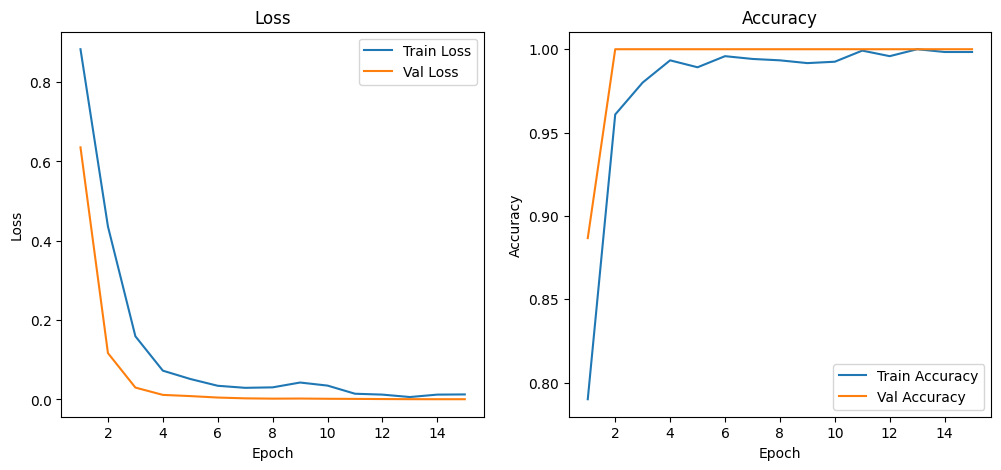

In [38]:
import matplotlib.pyplot as plt

SAVE_DIR = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/plots"

def plot_history(history):
    epochs = history['epoch']

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(SAVE_DIR, "loss_acc_sigbkg_1000.png"), dpi=300)
    plt.show()

# Dopo il training
plot_history(history)


Classification Report:
              precision    recall  f1-score   support

    t → bqq        1.00      1.00      1.00        50
         q/g       1.00      1.00      1.00        50
        0-ev       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



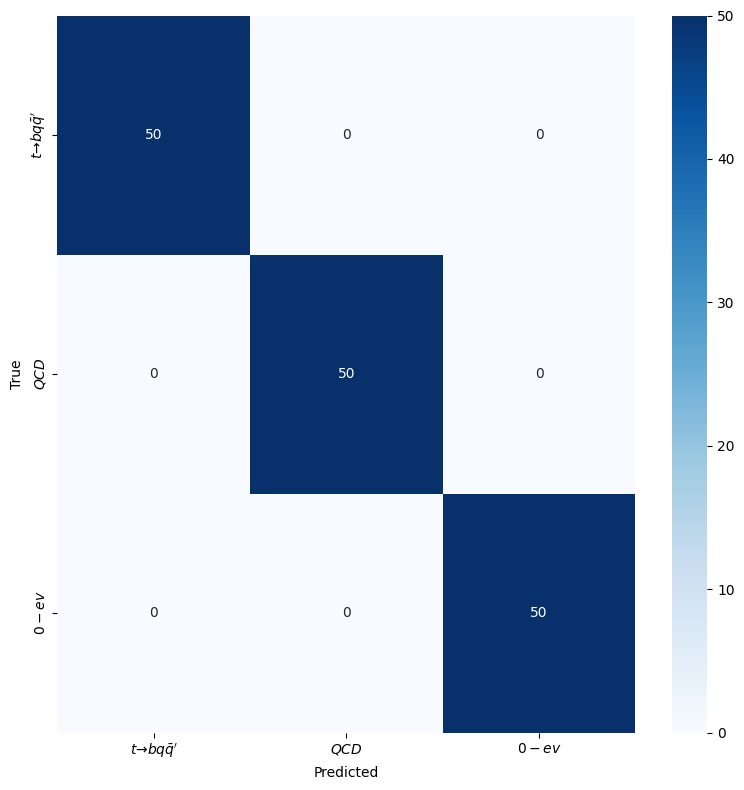

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os

# Percorso dove salvare le immagini
#SAVE_DIR = "/eos/user/f/fcampono/PAPER_Jet_Tagging/Run_01"
#os.makedirs(SAVE_DIR, exist_ok=True)

model = torch.load('/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt', map_location=DEVICE, weights_only= False)

def test_report(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels,_ in loader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1])  # probabilità classe positiva

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # === Classification Report ===
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['t → bqq ', 'q/g', '0-ev']))

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=[r"$t → bq\bar{q}'$", r"$QCD$",r"$0-ev$"],
                yticklabels=[r"$t → bq\bar{q}'$", r"$QCD$",r"$0-ev$"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    #plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix_sigbkg_1000.png"), dpi=300)
    plt.show()

# Esegui
test_report(model, test_loader)


In [40]:
# Lista delle immagini classificate correttamente dal modello
# ====== EVAL: ANALISI CORRETTE / SBAGLIATE ======
correct_samples = []
wrong_samples = []
model = torch.load('/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt', map_location=DEVICE, weights_only= False)

model.eval()
with torch.no_grad():
    for i, (imgs, labels,_) in enumerate(tqdm(test_loader, desc="Evaluating test set")):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        batch_start_idx = i * BATCH_SIZE
        batch_paths = test_files[batch_start_idx : batch_start_idx + len(imgs)]

        for path, pred, true_label in zip(batch_paths, preds.cpu().numpy(), labels.cpu().numpy()):
            if pred == true_label:
                correct_samples.append((path, true_label, pred))
            else:
                wrong_samples.append((path, true_label, pred))


correct_samples

Evaluating test set: 100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


[('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_002.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_009.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_011.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_022.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_033.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_039.npy',
  np.int64(0),
  np.int64(0)),
 ('/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroo

In [49]:
# BLACK FIGURE IN THE MODEL


# Imposta il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello
model = torch.load('/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt', map_location=DEVICE, weights_only= False)
model.to(device)
model.eval()

# Crea un'immagine completamente nera con forma [1, 3, 384, 384]
black_input = torch.zeros((1, 3, 224, 224), dtype=torch.float32).to(DEVICE)

# Ottieni predizione
with torch.no_grad():
    output = model(black_input)
    prob = torch.nn.functional.softmax(output, dim=1)
    pred_class = torch.argmax(prob, dim=1).item()
    conf = prob[0, pred_class].item()

# Mostra il risultato
print(f"🧪 Predizione su baseline nera:")
print(f"Classe predetta: {pred_class} (con confidenza {conf:.3f})")


🧪 Predizione su baseline nera:
Classe predetta: 2 (con confidenza 0.999)


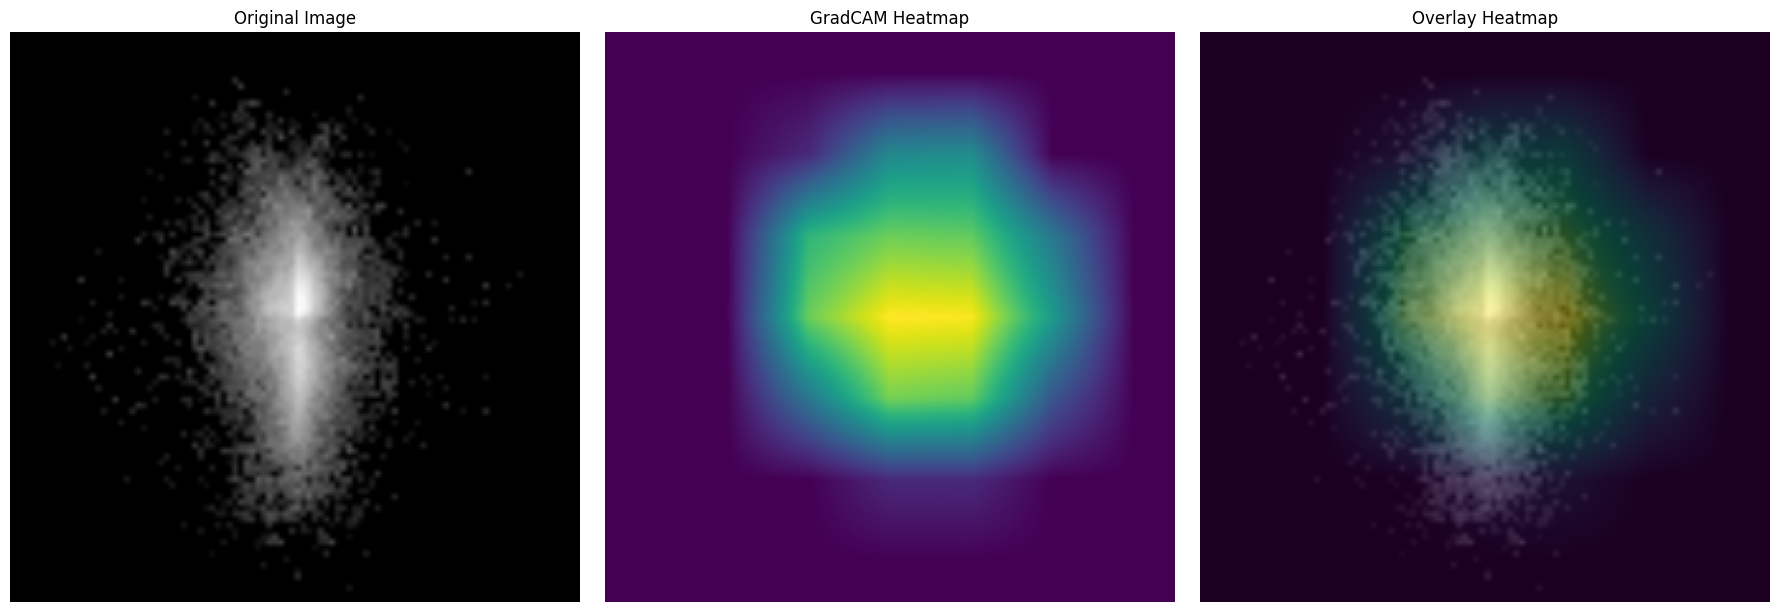

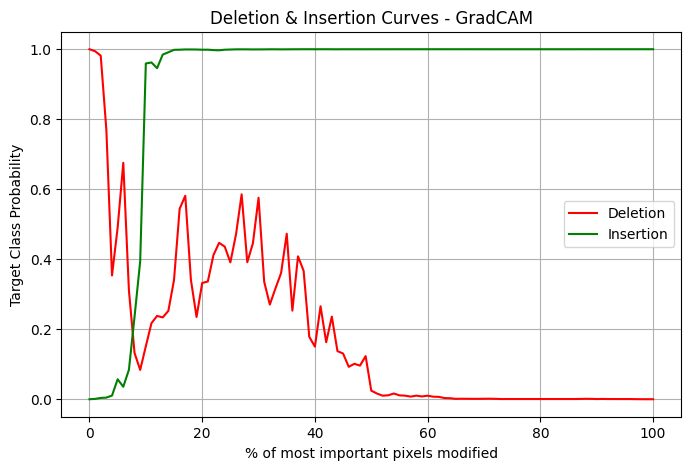

In [44]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2  # solo per il resize della CAM
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SIZE = 224

# ==== Preprocessing immagine identico al dataset ====
def preprocess_npy_image(npy_path, size=SIZE):
    image = np.load(npy_path).astype(np.float32)
    if np.max(image) > 0:
        image /= np.max(image)
    image_rgb = np.stack([image]*3, axis=-1)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((size, size))
    ])
    image_tensor = transform(image_rgb)
    return image_tensor, image_rgb  # tensor e immagine originale

# ==== Overlay e curve plotting ====
def plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves"):
    x = np.linspace(0, 100, len(del_scores))
    plt.figure(figsize=(8,5))
    plt.plot(x, del_scores, label="Deletion", color="red")
    plt.plot(x, ins_scores, label="Insertion", color="green")
    plt.xlabel("% of most important pixels modified")
    plt.ylabel("Target Class Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# =======================
# Main pipeline
# =======================
npy_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_TTBar_1000/TTBar_1000_fileroot_000_id_002.npy"

input_tensor, vis_image = preprocess_npy_image(npy_path, size=SIZE)
input_tensor = input_tensor.unsqueeze(0).to(device)

# Carica modello
model = torch.load(
    '/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt',
    map_location=device,
    weights_only=False
)
model.to(device)
model.eval()

with torch.no_grad():
    output = model(input_tensor)
    pred_label = torch.argmax(output, dim=1).item()

# GradCAM
target_layer = model.features[-1]
cam = GradCAM(model=model, target_layers=[target_layer])
grayscale_cam = cam(input_tensor, targets=[ClassifierOutputTarget(pred_label)])[0]

# Resize immagine per visualizzazione
vis_image_resized = cv2.resize(vis_image, (SIZE, SIZE))

# =======================
# Visualizzazione immagini
# =======================
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].imshow(vis_image_resized, cmap='grey', origin='lower')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(grayscale_cam, cmap='viridis', origin='lower')
axs[1].set_title("GradCAM Heatmap")
axs[1].axis("off")

axs[2].imshow(vis_image_resized, cmap='grey', origin='lower')
axs[2].imshow(grayscale_cam, cmap='viridis', origin='lower', alpha=0.4)
axs[2].set_title("Overlay Heatmap")
axs[2].axis("off")

plt.tight_layout()
plt.show()

# =======================
# Calcolo curve Deletion & Insertion con baseline blur
# =======================
del_scores = run_curve(
    model,
    image=input_tensor[0],
    cam=grayscale_cam,
    target_class=pred_label,
    mode='deletion',
    steps=100,
    baseline_type='zero',
    blur_kernel=1,
    blur_sigma=1
)

ins_scores = run_curve(
    model,
    image=input_tensor[0],
    cam=grayscale_cam,
    target_class=pred_label,
    mode='insertion',
    steps=100,
    baseline_type='zero',
    blur_kernel=1,
    blur_sigma=1
)

# Visualizza metriche
plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves - GradCAM")


In [45]:
from sklearn.metrics import auc

def compute_auc(scores: list) -> float:
    x = np.linspace(0, 1, len(scores))
    return auc(x, scores)
del_auc = compute_auc(del_scores)

ins_auc = compute_auc(ins_scores)

print(f"📉 Deletion AUC: {del_auc:.3f}")
print(f"📈 Insertion AUC: {ins_auc:.3f})")

📉 Deletion AUC: 0.179
📈 Insertion AUC: 0.911)


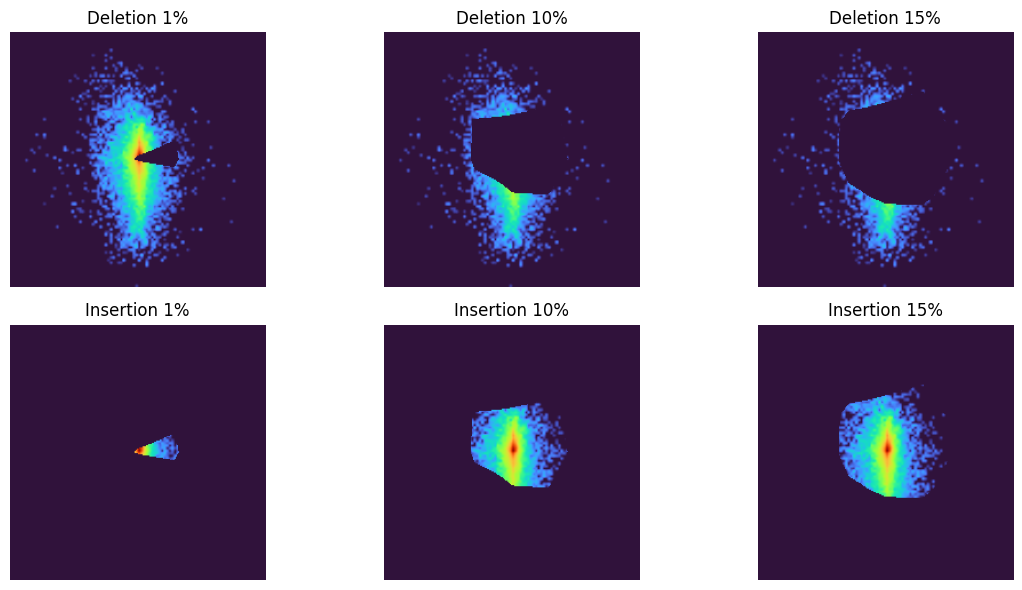

/tmp/ipykernel_1610/2131634400.py:279: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = cm.get_cmap('viridis')(grayscale_cam)[:, :, :3] # RGBA -> RGB


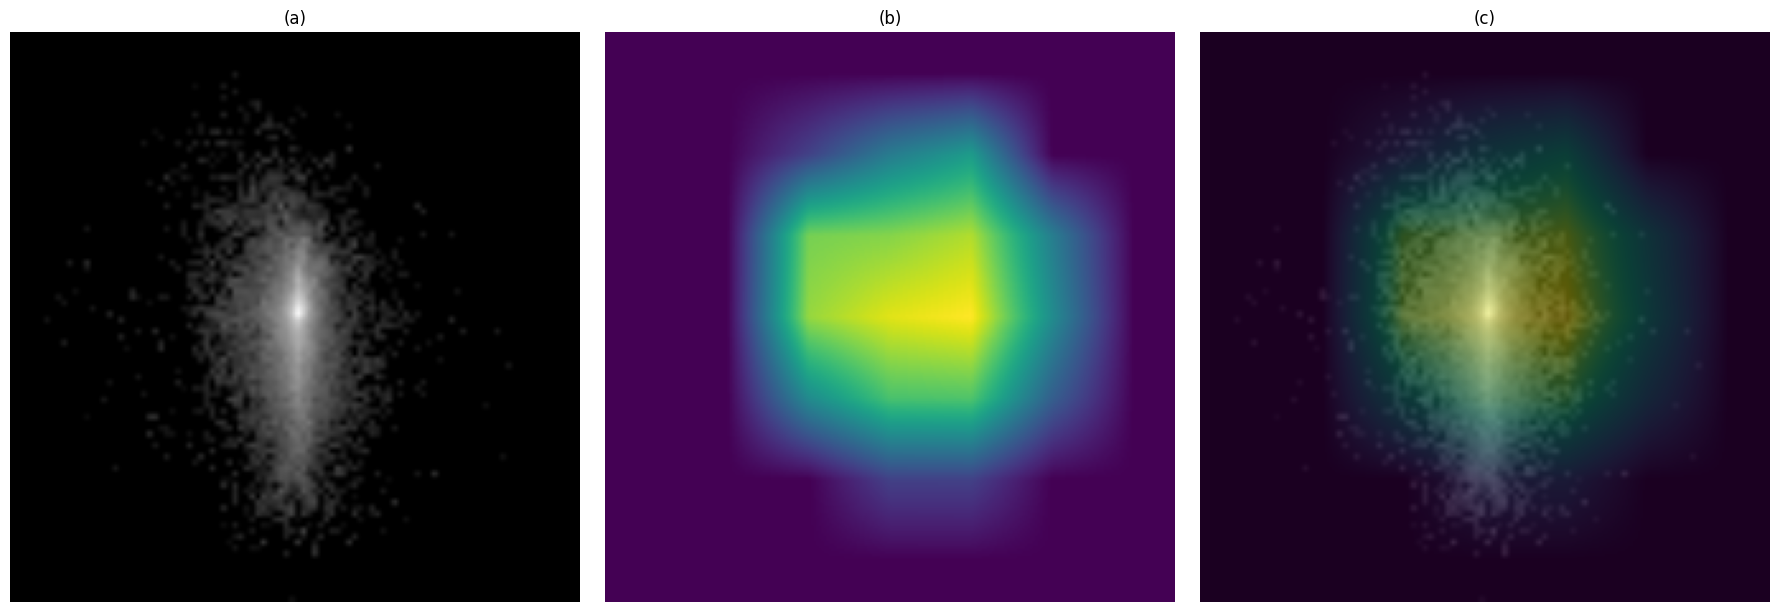


--- Calcolo Curve Deletion/Insertion (Blur) per la Classe 1 ---


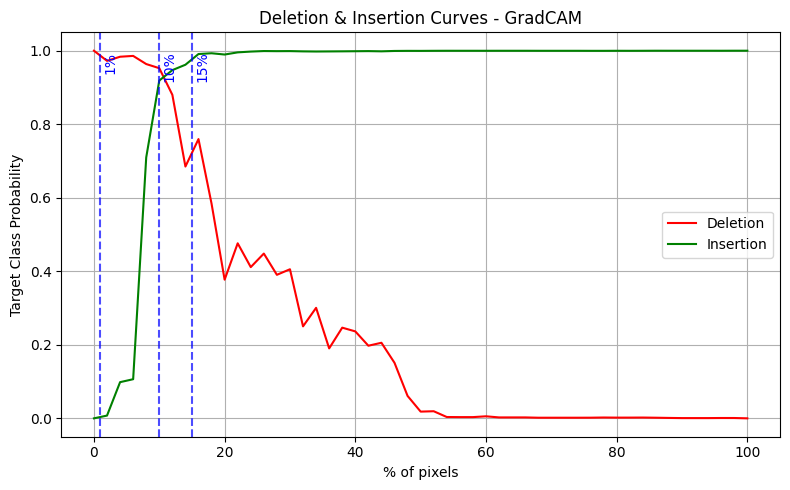

Baseline: zero
AUC Deletion  : 0.254
AUC Insertion : 0.923


/tmp/ipykernel_1610/2131634400.py:326: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(scores, x)


In [42]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from pytorch_grad_cam import EigenCAM, GradCAM # Mantenuto GradCAM per coerenza, anche se la lista mostrava EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.cm as cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- PARAMETRI GLOBALI PER LA SFOCATURA ---
BASELINE_MODE = "zero"   # "blur" oppure "zero"

BLUR_KERNEL_SIZE = 83 # Kernel più grande per una sfocatura più marcata
BLUR_SIGMA = 14      # Deviazione standard per il blur
# ------------------------------------------

# ===========================
# HELPER GAUSSIAN BLUR
# ===========================
def get_baseline(image: torch.Tensor,
                 mode="blur",
                 kernel_size=BLUR_KERNEL_SIZE,
                 sigma=BLUR_SIGMA):
    """
    Restituisce la baseline secondo la modalità scelta.
    """
    if mode == "blur":
        return gaussian_blur(image, kernel_size=kernel_size, sigma=sigma)
    elif mode == "zero":
        return torch.zeros_like(image)
    else:
        raise ValueError("baseline_mode must be 'blur' or 'zero'")



# ==== Preprocessing identico al dataset ====
def preprocess_npy_image(npy_path):
    """Carica e preprocessa l'immagine."""
    image = np.load(npy_path).astype(np.float32) # [100, 100]
    
    # Gestione forme (adatta per dataset Jet Tagging)
    if image.ndim == 2:
        image /= np.max(image) if np.max(image) > 0 else 1.0 # Normalizzazione
        image = np.stack([image] * 3, axis=-1) # [H, W, 3]
    elif image.ndim == 3 and image.shape[2] == 1:
        image = image[:,:,0]
        image /= np.max(image) if np.max(image) > 0 else 1.0 # Normalizzazione
        image = np.stack([image] * 3, axis=-1)
    else:
         image /= np.max(image) if np.max(image) > 0 else 1.0 # Normalizzazione

    transform = transforms.Compose([
        transforms.ToTensor(),              # [H, W, C] -> [C, H, W]
        # Usiamo antialias=True per buona pratica
        transforms.Resize((224, 224), antialias=True), 
    ])
    image_tensor = transform(image)
    return image_tensor, image

# =======================
# Funzioni Deletion/Insertion (AGGIORNATA per sfocatura)
# =======================
def apply_mask(image: torch.Tensor,
               mask: np.ndarray,
               mode='deletion',
               baseline: torch.Tensor = None) -> torch.Tensor:
    """
    Applica maschera usando una baseline arbitraria (blur o zero).
    """
    if baseline is None:
        raise ValueError("baseline must be provided.")

    device = image.device
    mask_t = torch.tensor(mask, dtype=torch.float32, device=device)
    mask_t = mask_t.unsqueeze(0).expand_as(image)

    baseline = baseline.to(device)

    if mode == 'deletion':
        return image * (1 - mask_t) + baseline * mask_t
    elif mode == 'insertion':
        return baseline * (1 - mask_t) + image * mask_t
    else:
        raise ValueError("Mode must be 'deletion' or 'insertion'.")



def show_masked_images_at_steps(image: torch.Tensor, cam: np.ndarray, 
                                steps_to_show=[0.01, 0.05, 0.15], 
                                save_path="/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Graphs/INSDEL_BLUR.png",
                                kernel_size=BLUR_KERNEL_SIZE, sigma=BLUR_SIGMA):
    """
    Visualizza immagini mascherate usando la sfocatura come baseline.
    """
    device = image.device

    # Calcola l'immagine sfocata (Baseline)
    blurred_baseline = gaussian_blur(image, kernel_size=kernel_size, sigma=sigma)
    baseline = get_baseline(
        image,
        mode=BASELINE_MODE,
        kernel_size=kernel_size,
        sigma=sigma
    ).to(device)
    # Assicuriamoci che la CAM abbia la dimensione dell'immagine (H, W)
    H, W = image.shape[1], image.shape[2]
    cam_resized = cv2.resize(cam, (W, H))
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

    flat = cam_resized.flatten()
    sorted_indices = np.argsort(flat)[::-1]

    # copy dell'immagine per sicurezza
    orig_np = image.cpu().numpy().transpose(1,2,0).copy()
    
    # Usiamo una cmap per visualizzare i getti (esempio 'turbo' o 'gray')
    cmap_plot = 'turbo' 

    fig, axs = plt.subplots(2, len(steps_to_show), figsize=(4*len(steps_to_show), 6))

    for col, pct in enumerate(steps_to_show):
        num_pixels = int(flat.size * pct)
        mask_flat = np.zeros_like(flat, dtype=np.float32)
        mask_flat[sorted_indices[:num_pixels]] = 1.0
        mask = mask_flat.reshape((H, W)) # 2D mask

        # ---- Creazione immagini con la baseline sfocata
        # deletion: sfocato dove c'è il getto
        del_img = apply_mask(image, mask, mode='deletion', baseline=baseline)
        ins_img = apply_mask(image, mask, mode='insertion', baseline=baseline)

        # Converti in numpy (H,W,C)
        del_img_np = np.clip(del_img.permute(1,2,0).cpu().numpy(), 0.0, 1.0)
        ins_img_np = np.clip(ins_img.permute(1,2,0).cpu().numpy(), 0.0, 1.0)

        # Grayscale per visualizzazione (o prendi il primo canale se sono simili)
        del_gray = del_img_np.mean(axis=-1)
        ins_gray = ins_img_np.mean(axis=-1)
        
        # -------------------------
        # PLOT DELETION (Sfocatura)
        # -------------------------
        ax = axs[0, col]
        ax.imshow(del_gray, cmap=cmap_plot, vmin=0, vmax=1, origin='lower')
        ax.set_title(f"Deletion {int(pct*100)}%")
        ax.axis('off')

        # -------------------------
        # PLOT INSERTION (Rivelazione)
        # -------------------------
        ax = axs[1, col]
        ax.imshow(ins_gray, cmap=cmap_plot, vmin=0, vmax=1, origin='lower')
        ax.set_title(f"Insertion {int(pct*100)}%")
        ax.axis('off')

    plt.tight_layout()
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #print(f"Saved INS/DEL (Blur) figure to: {save_path}")
    plt.show()


def run_curve(model, image: torch.Tensor, cam: np.ndarray, target_class: int, 
              mode='deletion', steps=50, kernel_size=BLUR_KERNEL_SIZE, sigma=BLUR_SIGMA):
    """Calcola i punteggi (probabilità) della curva usando la baseline sfocata."""
    model.eval()
    image = image.clone().detach().to(next(model.parameters()).device) # C, H, W

    baseline = get_baseline(
        image,
        mode=BASELINE_MODE,
        kernel_size=kernel_size,
        sigma=sigma
    )
            
    # Calcola l'immagine sfocata
    blurred_baseline = gaussian_blur(image, kernel_size=kernel_size, sigma=sigma)
    
    # Resize CAM
    cam = cv2.resize(cam, (image.shape[2], image.shape[1])) 
    cam = cam / (cam.max() + 1e-8)

    flat = cam.flatten()
    sorted_indices = np.argsort(flat)[::-1]

    scores = []
    for i in range(steps + 1):
        percent = i / steps
        num_pixels = int(flat.size * percent)

        mask = np.zeros_like(flat)
        mask[sorted_indices[:num_pixels]] = 1
        mask = mask.reshape(cam.shape)

        # Passa l'immagine sfocata come baseline
        # Nota: image è (C, H, W). apply_mask la gestisce, poi la rispacchettiamo per il modello
        masked_image = apply_mask(
            image,
            mask,
            mode=mode,
            baseline=baseline
        ).unsqueeze(0)

        with torch.no_grad():
            output = F.softmax(model(masked_image), dim=1)
            score = output[0, target_class].item()
            scores.append(score)

    return scores

# plot_curves (leggermente aggiornata nel titolo/legend)
def plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves"):
    x = np.linspace(0, 100, len(del_scores))
    plt.figure(figsize=(8, 5))
    plt.plot(x, del_scores, label="Deletion", color="red")
    plt.plot(x, ins_scores, label="Insertion", color="green")
    
    # Linee verticali a 1%, 5%, 10% e 20%
    for v in [1, 10, 15]:
        plt.axvline(x=v, color='blue', linestyle='--', alpha=0.7)
        plt.text(v + 0.5, plt.ylim()[1]*0.95, f'{v}%', color='blue', rotation=90, va='top')

    plt.xlabel("% of pixels")
    plt.ylabel("Target Class Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    #output_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Graphs/INSDEL_BLUR_xyplot.png"
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #print(f"Curve salvate in {output_path}")
    plt.show()


# =======================
# Main pipeline (AGGIORNATA)
# =======================
if __name__ == "__main__":
    
    # --- Configurazione Path ---
    npy_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/dataset_jet_10_1000/test/npy_QCD_1000/QCD_1000_fileroot_000_id_002.npy"
    model_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt"
    
    # 1. Preprocessing Immagine
    input_tensor, vis_image = preprocess_npy_image(npy_path)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # 2. Caricamento Modello
    model = torch.load(model_path, map_location=device, weights_only=False)    
    model.to(device)
    model.eval()

    # 3. Predizione e Calcolo CAM
    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    target_layer = model.features[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor, targets=[ClassifierOutputTarget(pred_label)])[0]
    #grayscale_cam = np.maximum(grayscale_cam, 0) # ReLU
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8) # normalizzazione 0-1

    # Rimuovi l'uso di baseline_img = torch.zeros_like(...) non serve più
    
    # 4. Visualizzazione immagini masked (ORA USA LA SFOCATURA)
    show_masked_images_at_steps(
        input_tensor[0], # (C, H, W)
        grayscale_cam, 
        steps_to_show=[0.01, 0.1, 0.15], 
        # La baseline (sfocata) viene calcolata internamente alla funzione
    )

    # 5. Visualizzazione heatmap + overlay (Invariata)
    heatmap = cm.get_cmap('viridis')(grayscale_cam)[:, :, :3] # RGBA -> RGB

    vis_image_resized = cv2.resize(vis_image, (224, 224))
    vis_image_resized = np.clip(vis_image_resized, 0, 1)

    alpha = 0.4
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1️⃣ Immagine originale (immutata)
    axs[0].imshow(vis_image_resized, origin='lower')
    axs[0].set_title("(a)")
    
    # 2️⃣ Heatmap da sola
    axs[1].imshow(heatmap, origin='lower')
    axs[1].set_title("(b)")
    
    # 3️⃣ Overlay VISIVO (no modifica pixel)
    axs[2].imshow(vis_image_resized, origin='lower')
    axs[2].imshow(heatmap, alpha=alpha, origin='lower')
    axs[2].set_title("(c)")
    
    for ax in axs:
        ax.axis("off")
    
    plt.tight_layout()
    #output_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Graphs/INSDEL_heatmap.png"
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #print(f"Overlay salvato in {output_path}")
    plt.show()

    # 6. Calcola curve (ORA USANO LA SFOCATURA)
    print(f"\n--- Calcolo Curve Deletion/Insertion (Blur) per la Classe {pred_label} ---")
    
    del_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label, mode='deletion', steps=50)
    ins_scores = run_curve(model, input_tensor[0], grayscale_cam, pred_label, mode='insertion', steps=50)
    
    # 7. Visualizza metriche
    plot_curves(del_scores, ins_scores, title="Deletion & Insertion Curves - GradCAM")


def compute_auc(scores):
    """
    scores: lista di probabilità (len = steps+1)
    ritorna AUC normalizzata in [0,1]
    """
    x = np.linspace(0, 1, len(scores))
    auc = np.trapz(scores, x)
    return auc
    
auc_del = compute_auc(del_scores)
auc_ins = compute_auc(ins_scores)

print(f"Baseline: {BASELINE_MODE}")
print(f"AUC Deletion  : {auc_del:.3f}")
print(f"AUC Insertion : {auc_ins:.3f}")


# ANALISI 

In [6]:
# ==== Caricamento modello ====
model_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/effnetv2s_sig_bkg_1000.pt"
model = torch.load(model_path, map_location=DEVICE, weights_only=False)
model.to(DEVICE)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [52]:
# === GRADCAM ===

target_layer = model.features[-1]
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

results_list = []

for inputs, labels, paths in tqdm(test_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        input_tensor = inputs[i].unsqueeze(0)
        true_label = labels[i].item()
        pred_label = preds[i].item()
        img_path = paths[i]

        # 1. Generazione Grad-CAM 
        # Identifica dove la rete vede i "prong" (centri di energia)
        grayscale_cam = cam_extractor(input_tensor, 
                                      targets=[ClassifierOutputTarget(pred_label)])[0]

        # 2. Definizione Baseline "Ground Zero" (Immagine Nera)
        # Fondamentale per dimostrare che la rete parte dal "nulla" (Classe 2)
        baseline_img = torch.zeros_like(input_tensor[0])

        # 3. Running Curve: Deletion (Rimuovo i prong dall'immagine originale)
        # Se l'accuratezza crolla subito, la morfologia 3-prong/1-prong era essenziale.
        del_scores = run_curve(model, 
                               input_tensor[0],
                               grayscale_cam, 
                               pred_label, 
                               mode='deletion', 
                               steps=100, 
                               baseline_type='zero') # Usa l'immagine nera come target

        # 4. Running Curve: Insertion (Parto da "Ground Zero" e incollo i prong)
        # Se l'accuratezza sale subito, i pochi pixel dei prong bastano a definire la natura dell'evento.
        ins_scores = run_curve(model, 
                               input_tensor[0], 
                               grayscale_cam, 
                               pred_label, 
                               mode='insertion', 
                               steps=100, 
                               baseline_type='zero') # Parte dall'immagine nera

        # Calcolo AUC (Area Under Curve) per quantificare la qualità della spiegazione
        x = np.linspace(0, 1, len(del_scores))
        auc_del = np.trapz(del_scores, x)
        auc_ins = np.trapz(ins_scores, x)

        correct = int(pred_label == true_label)

        # Salvataggio dati per analisi statistica nel paper
        results_list.append({
            'image_path': img_path,
            'true_label': true_label,
            'predicted_label': pred_label,
            'auc_deletion': auc_del,
            'auc_insertion': auc_ins,
            'correct': correct,
            'is_black_baseline': int(true_label == 2)
        })
# ==== SALVATAGGIO CSV ====
results_df = pd.DataFrame(results_list)
csv_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_gradcam.csv"
results_df.to_csv(csv_path, index=False)
print(f"\n📁 Risultati CSV salvati in: {csv_path}")

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_316/1616675404.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(del_scores, x)
/tmp/ipykernel_316/1616675404.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(ins_scores, x)
100%|██████████| 10/10 [10:43<00:00, 64.35s/it]


📁 Risultati CSV salvati in: /eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_gradcam.csv


In [56]:
# === GRADCAM ===

target_layer = model.features[-1]
cam_extractor = EigenCAM(model=model, target_layers=[target_layer])

results_list = []

for inputs, labels, paths in tqdm(test_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        input_tensor = inputs[i].unsqueeze(0)
        true_label = labels[i].item()
        pred_label = preds[i].item()
        img_path = paths[i]

        # 1. Generazione Grad-CAM 
        # Identifica dove la rete vede i "prong" (centri di energia)
        grayscale_cam = cam_extractor(input_tensor, 
                                      targets=[ClassifierOutputTarget(pred_label)])[0]

        # 2. Definizione Baseline "Ground Zero" (Immagine Nera)
        # Fondamentale per dimostrare che la rete parte dal "nulla" (Classe 2)
        baseline_img = torch.zeros_like(input_tensor[0])

        # 3. Running Curve: Deletion (Rimuovo i prong dall'immagine originale)
        # Se l'accuratezza crolla subito, la morfologia 3-prong/1-prong era essenziale.
        del_scores = run_curve(model, 
                               input_tensor[0],
                               grayscale_cam, 
                               pred_label, 
                               mode='deletion', 
                               steps=100, 
                               baseline_type='zero') # Usa l'immagine nera come target

        # 4. Running Curve: Insertion (Parto da "Ground Zero" e incollo i prong)
        # Se l'accuratezza sale subito, i pochi pixel dei prong bastano a definire la natura dell'evento.
        ins_scores = run_curve(model, 
                               input_tensor[0], 
                               grayscale_cam, 
                               pred_label, 
                               mode='insertion', 
                               steps=100, 
                               baseline_type='zero') # Parte dall'immagine nera

        # Calcolo AUC (Area Under Curve) per quantificare la qualità della spiegazione
        x = np.linspace(0, 1, len(del_scores))
        auc_del = np.trapz(del_scores, x)
        auc_ins = np.trapz(ins_scores, x)

        correct = int(pred_label == true_label)

        # Salvataggio dati per analisi statistica nel paper
        results_list.append({
            'image_path': img_path,
            'true_label': true_label,
            'predicted_label': pred_label,
            'auc_deletion': auc_del,
            'auc_insertion': auc_ins,
            'correct': correct,
            'is_black_baseline': int(true_label == 2)
        })
# ==== SALVATAGGIO CSV ====
results_df = pd.DataFrame(results_list)
csv_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_eigencam.csv"
results_df.to_csv(csv_path, index=False)
print(f"\n📁 Risultati CSV salvati in: {csv_path}")

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_316/1050957424.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(del_scores, x)
/tmp/ipykernel_316/1050957424.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(ins_scores, x)
100%|██████████| 10/10 [10:46<00:00, 64.61s/it]


📁 Risultati CSV salvati in: /eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_eigencam.csv


In [57]:
# === GRADCAM ===

target_layer = model.features[-1]
cam_extractor = ScoreCAM(model=model, target_layers=[target_layer])

results_list = []

for inputs, labels, paths in tqdm(test_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        input_tensor = inputs[i].unsqueeze(0)
        true_label = labels[i].item()
        pred_label = preds[i].item()
        img_path = paths[i]

        # 1. Generazione Grad-CAM 
        # Identifica dove la rete vede i "prong" (centri di energia)
        grayscale_cam = cam_extractor(input_tensor, 
                                      targets=[ClassifierOutputTarget(pred_label)])[0]

        # 2. Definizione Baseline "Ground Zero" (Immagine Nera)
        # Fondamentale per dimostrare che la rete parte dal "nulla" (Classe 2)
        baseline_img = torch.zeros_like(input_tensor[0])

        # 3. Running Curve: Deletion (Rimuovo i prong dall'immagine originale)
        # Se l'accuratezza crolla subito, la morfologia 3-prong/1-prong era essenziale.
        del_scores = run_curve(model, 
                               input_tensor[0],
                               grayscale_cam, 
                               pred_label, 
                               mode='deletion', 
                               steps=100, 
                               baseline_type='zero') # Usa l'immagine nera come target

        # 4. Running Curve: Insertion (Parto da "Ground Zero" e incollo i prong)
        # Se l'accuratezza sale subito, i pochi pixel dei prong bastano a definire la natura dell'evento.
        ins_scores = run_curve(model, 
                               input_tensor[0], 
                               grayscale_cam, 
                               pred_label, 
                               mode='insertion', 
                               steps=100, 
                               baseline_type='zero') # Parte dall'immagine nera

        # Calcolo AUC (Area Under Curve) per quantificare la qualità della spiegazione
        x = np.linspace(0, 1, len(del_scores))
        auc_del = np.trapz(del_scores, x)
        auc_ins = np.trapz(ins_scores, x)

        correct = int(pred_label == true_label)

        # Salvataggio dati per analisi statistica nel paper
        results_list.append({
            'image_path': img_path,
            'true_label': true_label,
            'predicted_label': pred_label,
            'auc_deletion': auc_del,
            'auc_insertion': auc_ins,
            'correct': correct,
            'is_black_baseline': int(true_label == 2)
        })
# ==== SALVATAGGIO CSV ====
results_df = pd.DataFrame(results_list)
csv_path = "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_scorecam.csv"
results_df.to_csv(csv_path, index=False)
print(f"\n📁 Risultati CSV salvati in: {csv_path}")

100%|██████████| 80/80 [00:02<00:00, 31.32it/s]
/tmp/ipykernel_316/90573185.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(del_scores, x)
/tmp/ipykernel_316/90573185.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(ins_scores, x)

100%|██████████| 80/80 [00:02<00:00, 34.37it/s]

100%|██████████| 80/80 [00:02<00:00, 34.66it/s]

100%|██████████| 80/80 [00:02<00:00, 34.42it/s]

100%|██████████| 80/80 [00:02<00:00, 34.41it/s]

100%|██████████| 80/80 [00:02<00:00, 35.45it/s]

100%|██████████| 80/80 [00:02<00:00, 34.57it/s]

100%|██████████| 80/80 [00:02<00:00, 34.29it/s]

100%|██████████| 80/80 [00:02<00:00, 35.28it/s]

100%|██████████| 80/80 [00:02<00:00, 35.19it/s]

100%|██████████| 80/80 [00:02<00:00, 35.50it/s]

100%|██████████| 80/80 [00:02<00:00, 34.59it/s]


📁 Risultati CSV salvati in: /eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_scorecam.csv


# OUTLIER

In [16]:
def get_stats(df, label=None, correct_only=False, prefix=""):
    """Calcola mean, std, median e iqr per auc_insertion e auc_deletion."""
    subset = df.copy()
    if label is not None:
        subset = subset.loc[subset["true_label"] == label]
    if correct_only:
        subset = subset.loc[subset["correct"] == 1]

    stats = {}
    for col in ["auc_insertion", "auc_deletion"]:
        data = subset[col].dropna()
        stats[f"{prefix}mean_{col}"] = data.mean()
        stats[f"{prefix}std_{col}"] = data.std(ddof=1)
        stats[f"{prefix}median_{col}"] = data.median()
        stats[f"{prefix}iqr_{col}"] = data.quantile(0.75) - data.quantile(0.25)
    return stats


def print_stats(stats, label_name="HBB", correct_only=False):
    title = f"=== {label_name} {'(solo classificate correttamente)' if correct_only else '(class + misclass)'} ==="
    print(f"\n{title}\n")
    
    print("INSERTION")
    #print(f"mean value ins: {stats['mean_auc_insertion']:.2f}")
    #print(f"dev std ins: {stats['std_auc_insertion']:.2f}")
    print(f"median ins: {stats['median_auc_insertion']:.3f}")
    print(f"iqr ins: {stats['iqr_auc_insertion']:.3f}")
    
    print("\nDELETION")
    #print(f"mean value del: {stats['mean_auc_deletion']:.2f}")
    #print(f"dev std del: {stats['std_auc_deletion']:.2f}")
    print(f"median del: {stats['median_auc_deletion']:.3f}")
    print(f"iqr del: {stats['iqr_auc_deletion']:.3f}")

df_grad = pd.read_csv("/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_gradcam.csv")
df_eigen = pd.read_csv("/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_eigencam.csv")
df_score = pd.read_csv("/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_scorecam.csv")

df = df_score

# === ESEMPIO DI UTILIZZO ===

# Tutto il test set (entrambe le classi)
#all_samples = get_stats(df_sco, label=None, correct_only=False)
#all_correct = get_stats(df_sco, label=None, correct_only=True)

# H→bb̄ (true_label = 0)
ttbar_all = get_stats(df, label=0, correct_only=False)
ttbar_correct = get_stats(df, label=0, correct_only=True)

# H→cc̄ (true_label = 1)
qcd_all = get_stats(df, label=1, correct_only=False)
qcd_correct = get_stats(df, label=1, correct_only=True)

# 0-ev (true_label = 2)
#zeroev_all = get_stats(df, label=2, correct_only=False)
#zeroev_correct = get_stats(df, label=2, correct_only=True)

# === STAMPA RISULTATI ===
#print_stats(all_samples, label_name="HBB + HCC", correct_only=False)
#print_stats(all_correct, label_name="HBB + HCC", correct_only=True)
print_stats(ttbar_all, label_name="TTBar", correct_only=False)
#print_stats(ttbar_correct, label_name="TTBar", correct_only=True)
print_stats(qcd_all, label_name="QCD", correct_only=False)
#print_stats(qcd_correct, label_name="QCD", correct_only=True)
#print_stats(zeroev_all, label_name="0-ev", correct_only=False)
#print_stats(zeroev_correct, label_name="0-ev", correct_only=True)


=== TTBar (class + misclass) ===

INSERTION
median ins: 0.908
iqr ins: 0.009

DELETION
median del: 0.199
iqr del: 0.023

=== QCD (class + misclass) ===

INSERTION
median ins: 0.906
iqr ins: 0.014

DELETION
median del: 0.236
iqr del: 0.023


/tmp/ipykernel_348/4066293032.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
/tmp/ipykernel_348/4066293032.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


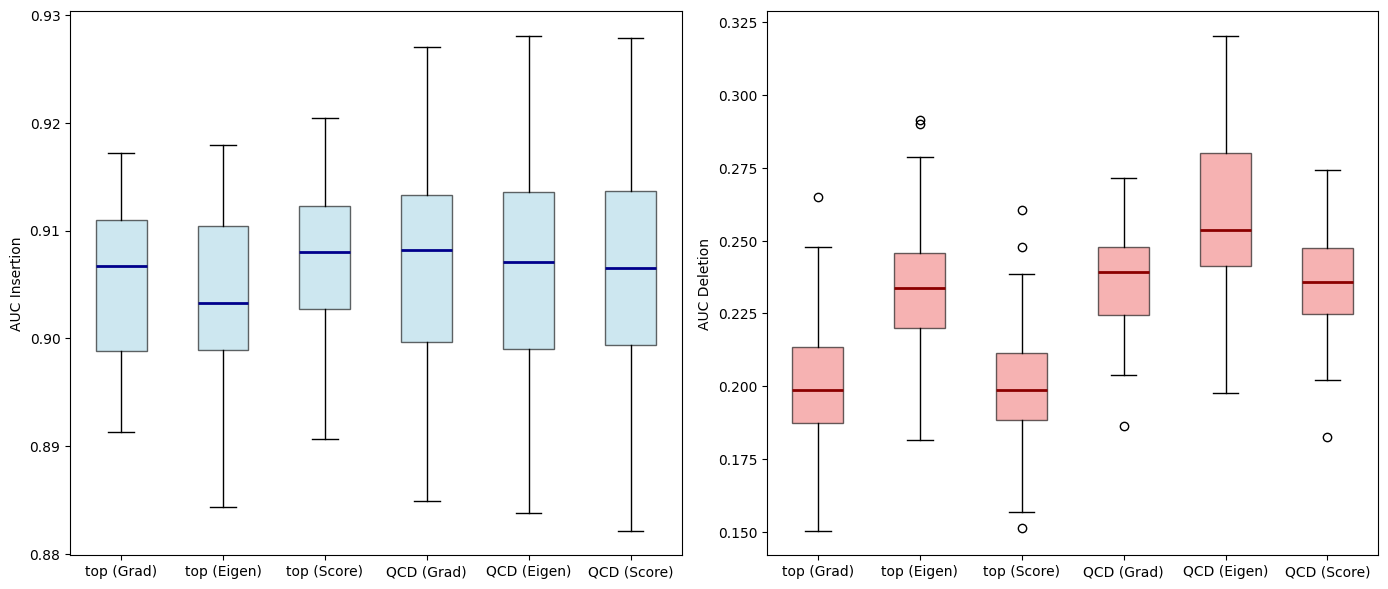

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# === CSV paths ===
files = {
    "Grad": "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_gradcam.csv",
    "Eigen": "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_eigencam.csv",
    "ScoreCAM": "/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_scorecam.csv",
}

data = {}

# === Load all CSVs ===
for method, path in files.items():
    df = pd.read_csv(path)

    if "true_label" not in df.columns:
        df["true_label"] = [0]*50 + [1]*50

    data[method] = {
        "Top_ins": df[df["true_label"] == 0]["auc_insertion"],
        "QCD_ins": df[df["true_label"] == 1]["auc_insertion"],
        "Top_del": df[df["true_label"] == 0]["auc_deletion"],
        "QCD_del": df[df["true_label"] == 1]["auc_deletion"],
    }

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#plt.subplots_adjust(wspace=0.35)

# -------- INSERTION --------
ins_data = [
    data["Grad"]["Top_ins"], data["Eigen"]["Top_ins"], data["ScoreCAM"]["Top_ins"],
    data["Grad"]["QCD_ins"], data["Eigen"]["QCD_ins"], data["ScoreCAM"]["QCD_ins"],
]

axes[0].boxplot(
    ins_data,
    labels=[
        "top (Grad)", "top (Eigen)", "top (Score)",
        "QCD (Grad)", "QCD (Eigen)", "QCD (Score)",
    ],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", alpha=0.6),
    medianprops=dict(color="darkblue", linewidth=2),
)
axes[0].set_ylabel("AUC Insertion")
axes[0].tick_params(axis='x', rotation=0)

# -------- DELETION --------
del_data = [
    data["Grad"]["Top_del"], data["Eigen"]["Top_del"], data["ScoreCAM"]["Top_del"],
    data["Grad"]["QCD_del"], data["Eigen"]["QCD_del"], data["ScoreCAM"]["QCD_del"],
]

axes[1].boxplot(
    del_data,
    labels=[
        "top (Grad)", "top (Eigen)", "top (Score)",
        "QCD (Grad)", "QCD (Eigen)", "QCD (Score)",
    ],
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral", alpha=0.6),
    medianprops=dict(color="darkred", linewidth=2),
)
axes[1].set_ylabel("AUC Deletion")
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
# plt.savefig("expl_comparison_all_methods_top_qcd_C1.png", dpi=300)
plt.show()


In [5]:
# FOR THE outlier


import pandas as pd

# === Load your CSV file ===
df = pd.read_csv("/eos/user/f/fcampono/PAPER_Jet_Tagging/simulations/Run_01/csv_results/sig_bkg_1000_scorecam.csv")

# Add correctness flag
df["correct"] = df["true_label"] == df["predicted_label"]

# Helper function to compute outliers
def find_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = series[(series < lower) | (series > upper)]
    return {
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower": lower,
        "upper": upper,
        "n_outliers": len(outliers),
        "outlier_indices": outliers.index.tolist()
    }

# Define groups
groups = {
    "TTBar_ins": df[df["true_label"] == 0]["auc_insertion"],
    #"TTBar_C2_ins": df[(df["true_label"] == 0) & (df["correct"])]["auc_insertion"],
    "QCD_ins": df[df["true_label"] == 1]["auc_insertion"],
    #"QCD_C2_ins": df[(df["true_label"] == 1) & (df["correct"])]["auc_insertion"],
    "TTBar_del": df[df["true_label"] == 0]["auc_deletion"],
    #"TTBar_C2_del": df[(df["true_label"] == 0) & (df["correct"])]["auc_deletion"],
    "QCD_del": df[df["true_label"] == 1]["auc_deletion"],
    #"QCD_C2_del": df[(df["true_label"] == 1) & (df["correct"])]["auc_deletion"],
}

# Compute and print summary with outlier percentages
for name, series in groups.items():
    stats = find_outliers(series)
    n_total = len(series)
    outlier_pct = (stats['n_outliers'] / n_total) * 100
    print(f"\n=== {name} ===")
    print(f"Median: {series.median():.3f}")
    print(f"IQR: {stats['IQR']:.3f}")
    print(f"Lower / Upper fence: [{stats['lower']:.3f}, {stats['upper']:.3f}]")
    print(f"Outliers: {stats['n_outliers']} ({outlier_pct:.2f}%)")
    if stats['n_outliers'] > 0:
        print(f" → indices: {stats['outlier_indices']}")



=== TTBar_ins ===
Median: 0.908
IQR: 0.009
Lower / Upper fence: [0.889, 0.926]
Outliers: 0 (0.00%)

=== QCD_ins ===
Median: 0.906
IQR: 0.014
Lower / Upper fence: [0.878, 0.935]
Outliers: 0 (0.00%)

=== TTBar_del ===
Median: 0.199
IQR: 0.023
Lower / Upper fence: [0.154, 0.246]
Outliers: 3 (6.00%)
 → indices: [10, 17, 38]

=== QCD_del ===
Median: 0.236
IQR: 0.023
Lower / Upper fence: [0.191, 0.281]
Outliers: 1 (2.00%)
 → indices: [70]


In [4]:
import pandas as pd
import numpy as np

# Input data from the table
data = {
    "Method": ["GradCAM", "EigenCAM", "ScoreCAM"],
    "top_rho_I": [0.907, 0.903, 0.908],
    "top_alpha_I": [0.012, 0.012, 0.009],
    "top_rho_D": [0.199, 0.234, 0.199],
    "top_alpha_D": [0.026, 0.026, 0.023],
    "qcd_rho_I": [0.908, 0.907, 0.906],
    "qcd_alpha_I": [0.014, 0.015, 0.014],
    "qcd_rho_D": [0.239, 0.253, 0.236],
    "qcd_alpha_D": [0.023, 0.039, 0.023],
}

df = pd.DataFrame(data)

# Epsilon formula
def epsilon(rho_I, rho_D, alpha_I, alpha_D):
    return (rho_I - rho_D) / np.sqrt(alpha_I**2 + alpha_D**2)

# Compute epsilon for top and QCD
df["epsilon_top"] = epsilon(df["top_rho_I"], df["top_rho_D"],
                            df["top_alpha_I"], df["top_alpha_D"])

df["epsilon_qcd"] = epsilon(df["qcd_rho_I"], df["qcd_rho_D"],
                            df["qcd_alpha_I"], df["qcd_alpha_D"])

print(df)

     Method  top_rho_I  top_alpha_I  top_rho_D  top_alpha_D  qcd_rho_I  \
0   GradCAM      0.907        0.012      0.199        0.026      0.908   
1  EigenCAM      0.903        0.012      0.234        0.026      0.907   
2  ScoreCAM      0.908        0.009      0.199        0.023      0.906   

   qcd_alpha_I  qcd_rho_D  qcd_alpha_D  epsilon_top  epsilon_qcd  
0        0.014      0.239        0.023    24.724432    24.846036  
1        0.015      0.253        0.039    23.362493    15.651488  
2        0.014      0.236        0.023    28.706571    24.883175  
